# Prelim

Dataset downloaded from : https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_unsorted_10k

Data is available at `s3://fh-pi-setty-m-eco-public/single-cell-primers/multiome/`

ArchR preprocessing script: https://github.com/settylab/single-cell-primers/blob/main/scripts/PBMC-mulitome-ATAC-ArchR-preprocessing.R

Review the notebook `PBMC-RNA-standalone.ipynb` for setup instructions.

In [1]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

In [2]:
import palantir 
import phenograph
import harmony

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [4]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [5]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr

In [6]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc

def _dot_func(x, y):
    return x.dot(y)

def imputation_weights(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)
        
    ad.obsp['ImputeWeights'] = T_steps

def impute_data_with_weights(ad, data):
    res = _dot_func(ad.obsp['ImputeWeights'], data)
    return pd.DataFrame(res, index=ad.obs_names, columns=data.columns)
    


# Load data

## ATAC

In [7]:
data_dir = os.path.expanduser('data/multiome/ArchR/pbmc_multiome_atac/export/')

Load all the exported results from ArchR

### Peaks data

In [8]:
# Peaks data
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')

In [9]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()

,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,nearestGene,distToGeneStart,peakType,distToTSS,nearestTSS,GC,idx,N
chr1:817086-817586,chr1,817086,817586,501,*,82.4090,0.928,0.808,2,C3._.Rep1,FAM87B,35,Promoter,34,uc057aum.1,0.4790,1,0
chr1:827297-827797,chr1,827297,827797,501,*,128.7800,0.969,0.920,2,C16._.Rep1,LINC01128,2409,Promoter,24,uc057auo.1,0.6886,2,0
chr1:842049-842549,chr1,842049,842549,501,*,3.3114,0.347,0.073,2,C9._.Rep2,LINC01128,17161,Intronic,9048,uc057auo.1,0.5569,3,0
chr1:844395-844895,chr1,844395,844895,501,*,12.1918,0.871,0.705,2,C11._.Rep2,LINC01128,19507,Intronic,6702,uc057auo.1,0.5190,4,0
chr1:857901-858401,chr1,857901,858401,501,*,20.4632,0.566,0.287,2,C8._.Rep1,LINC01128,33013,Exonic,6802,uc057auo.1,0.3832,5,0


In [10]:
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in peaks.columns:
    ad.var[col] = peaks[col]

/loc/scratch/8137247/ipykernel_13047/1812160205.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(counts.T)


In [11]:
ad.X = ad.X.tocsr()

In [12]:
ad

AnnData object with n_obs × n_vars = 11049 × 150360
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'

### SVD, UMAP and Metadata

In [13]:
# SVD
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

In [14]:
# UMAP
ad.obsm['X_umap_archr'] = pd.read_csv(data_dir + 'umap.csv', index_col=0).loc[ad.obs_names, : ].values

In [15]:
# Metadata
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values

In [16]:
ad

AnnData object with n_obs × n_vars = 11049 × 150360
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    obsm: 'X_svd', 'X_umap_archr'

### Gene scores

In [17]:
# Gene scores
scores = mmread(data_dir + 'gene_scores/scores.mtx')

In [18]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'gene_scores/cells.csv', index_col=0).iloc[:, 0]
genes = pd.read_csv(data_dir + 'gene_scores/genes.csv', index_col=0).iloc[:, 0]


In [19]:
gs_ad = sc.AnnData(scores.T.tocsr(), dtype=np.float32)
gs_ad.obs_names, gs_ad.var_names = cells, genes

In [20]:
gs_ad.var_names_make_unique()

In [21]:
ad.obsm['GeneScores'] = gs_ad[ad.obs_names,:].X
ad.uns['GeneScoresColumns'] = np.array(gs_ad.var_names)

In [22]:
ad

AnnData object with n_obs × n_vars = 11049 × 150360
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColumns'
    obsm: 'X_svd', 'X_umap_archr', 'GeneScores'

### chromVAR

In [23]:
chromvar = pd.read_csv(data_dir + 'chromvar_motif_scores.csv', index_col=0)
chromvar

,pbmc_multiome#TCCCGGACACAAAGCG-1,pbmc_multiome#GAGAACCAGGGCTTTG-1,pbmc_multiome#TTAGGAACAGAGAGCC-1,pbmc_multiome#TGTGGCCAGTGATTCA-1,pbmc_multiome#GCCGTGAGTCAGTAAT-1,pbmc_multiome#AAGCGAATCAAAGGCA-1,pbmc_multiome#CTAGTAGGTCAACAAT-1,pbmc_multiome#AGCGGATAGTTTGGTA-1,pbmc_multiome#ACGGGAAGTTAAGCGC-1,pbmc_multiome#TGTATCCGTCACCAAA-1,...,pbmc_multiome#GTACCTTGTCCCGAAG-1,pbmc_multiome#GAAGGATGTCTAGCTT-1,pbmc_multiome#GCGGTTATCCTTAGTT-1,pbmc_multiome#TTCGTGCTCACTAGGT-1,pbmc_multiome#TGGTCAAGTAGTTACG-1,pbmc_multiome#GAAAGGCTCAGCATTA-1,pbmc_multiome#AGACTATGTGACATAT-1,pbmc_multiome#ACTTAGTCAGGTTCAC-1,pbmc_multiome#CTAACCCTCCTGGCTT-1,pbmc_multiome#CTAATGTCACCTACTT-1
TFAP2B_1,-1.827371,1.240846,1.021839,-0.648502,-0.021712,-0.377622,-0.743025,-2.048289,0.439421,-0.965715,...,-0.341866,0.573332,1.973076,-0.086938,0.934423,1.588016,1.347929,0.114737,-0.195835,-0.336190
TFAP2D_2,-0.286915,-0.996712,0.592149,0.057825,0.083670,0.284603,0.231828,-0.991343,0.679255,-0.123934,...,1.445983,-1.218937,-0.423596,1.011284,0.848540,-0.411439,0.611479,-0.725094,0.868191,-0.803027
TFAP2C_3,-3.871100,0.776406,0.881424,1.012064,-1.312316,-1.792538,-1.515943,0.170530,1.663011,-1.719564,...,-0.879967,1.142923,0.258483,-1.698755,-0.522800,0.331712,0.496788,0.135910,-2.443716,-1.761843
TFAP2E_4,-0.252261,-2.289721,0.047012,1.000438,-0.180995,-1.214828,-0.592344,-1.198537,0.043363,-0.342157,...,0.720515,-0.005253,0.078068,0.447426,-1.732389,1.685772,1.527390,1.940301,-1.121974,-1.477603
TFAP2A_5,0.117450,-0.413160,0.219578,-0.763483,-0.621284,0.284239,-0.740089,0.257777,1.830175,-0.904566,...,-1.810748,1.193637,-1.136978,-0.598458,0.039449,1.497332,1.220226,0.997220,-0.069571,-1.666839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMAD5_866,-0.079521,-0.393426,-0.241925,0.746888,1.781344,0.909884,1.096896,0.449106,0.599415,-0.330934,...,0.438847,0.283596,0.610529,-1.085506,1.040715,-0.914203,-0.543170,-0.709290,1.471135,0.196504
SMAD9_867,-1.228113,-0.103022,0.388920,-2.725046,-0.589432,-0.897336,-2.719645,-0.729627,-0.850377,-0.053286,...,-0.268375,0.223750,2.907853,-1.546602,-1.092849,-0.409411,0.397949,-2.232768,-0.700671,-0.949999
SOX6_868,1.749681,-1.618483,-0.531900,-0.475195,1.891766,2.211221,-1.839195,-0.400350,-1.338769,0.636625,...,1.092198,2.065414,-0.408593,0.352178,-0.582022,1.389824,0.682980,-0.342679,-0.871846,-0.514563
TBX18_869,0.956912,1.458301,-1.165599,-0.536890,-0.341244,-1.034188,-0.280994,0.795222,-2.030574,1.991727,...,-0.319031,0.215687,-0.080312,0.202282,0.262130,0.210639,0.535007,-0.075944,-1.267956,0.035093


In [24]:
ad.obsm['chromVAR'] = chromvar.T.loc[ad.obs_names, :]

In [25]:
ad

AnnData object with n_obs × n_vars = 11049 × 150360
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColumns'
    obsm: 'X_svd', 'X_umap_archr', 'GeneScores', 'chromVAR'


Add the features.tsv to the Anndata to allow matching of gene names to ENSEMBL IDs.

In [26]:
ad.uns['features'] = pd.read_csv( "data/multiome/filtered_feature_bc_matrix/features.tsv.gz")

In [27]:
ad

AnnData object with n_obs × n_vars = 11049 × 150360
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColumns', 'features'
    obsm: 'X_svd', 'X_umap_archr', 'GeneScores', 'chromVAR'

# Preprocessing

In [28]:
# Diffusion maps using SVD
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_svd'], index=ad.obs_names))
ad.obsp['DM_Kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors'] = dm_res['EigenVectors'].values
ad.uns['DMEigenValues'] = dm_res['EigenValues'].values
ad

Determing nearest neighbor graph...


/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/palantir/utils.py:56: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)
2023-01-25 15:46:15.351669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 15:46:15.547133: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variabl

AnnData object with n_obs × n_vars = 11049 × 150360
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColumns', 'features', 'DMEigenValues'
    obsm: 'X_svd', 'X_umap_archr', 'GeneScores', 'chromVAR', 'DM_EigenVectors'
    obsp: 'DM_Kernel'

In [29]:
# Imputation weights
imputation_weights(dm_res, ad)

# Visualizations

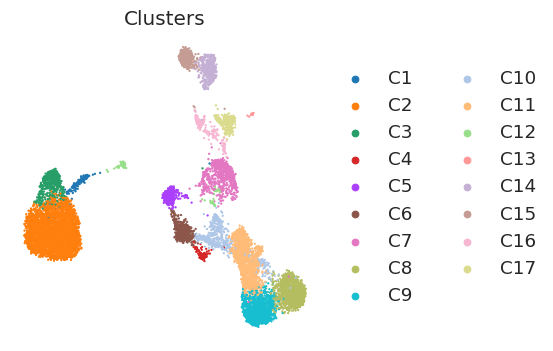

In [30]:
sc.pl.embedding(ad, basis='umap_archr', color='Clusters', frameon=False)

# Imputation examples

## Gene scores

In [31]:
gs_ad = sc.AnnData(ad.obsm['GeneScores'], dtype=np.float32)
gs_ad.obs_names, gs_ad.var_names = ad.obs_names, ad.uns['GeneScoresColumns']
gs_ad.obsm['X_umap'] = ad.obsm['X_umap_archr']

In [32]:
genes = pd.Series([
    "CD34",  #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", "MS4A1", "MME", #B-Cell Trajectory
    "CD14",  #Monocytes
    "CD3D", "CD8A", 'CD4', #TCells,
    'FCGR3A', #'CD16', 
     'LEF1', 'NKG7', 'TREM1', 'LYZ', 'CD19',  'IRF8', 'IRF4',
    'ITGA2B', # CD41,
    'NCAM1', # CD56,
    'CCR7' # Memory T cell
])
genes = genes[genes.isin(ad.uns['GeneScoresColumns'])]

In [33]:
# Create a dense matrix with interesting genes
data = pd.DataFrame(gs_ad[:, genes].X.todense(), index=gs_ad.obs_names, columns=genes)
# Impute
imputed_data = impute_data_with_weights(ad, data)

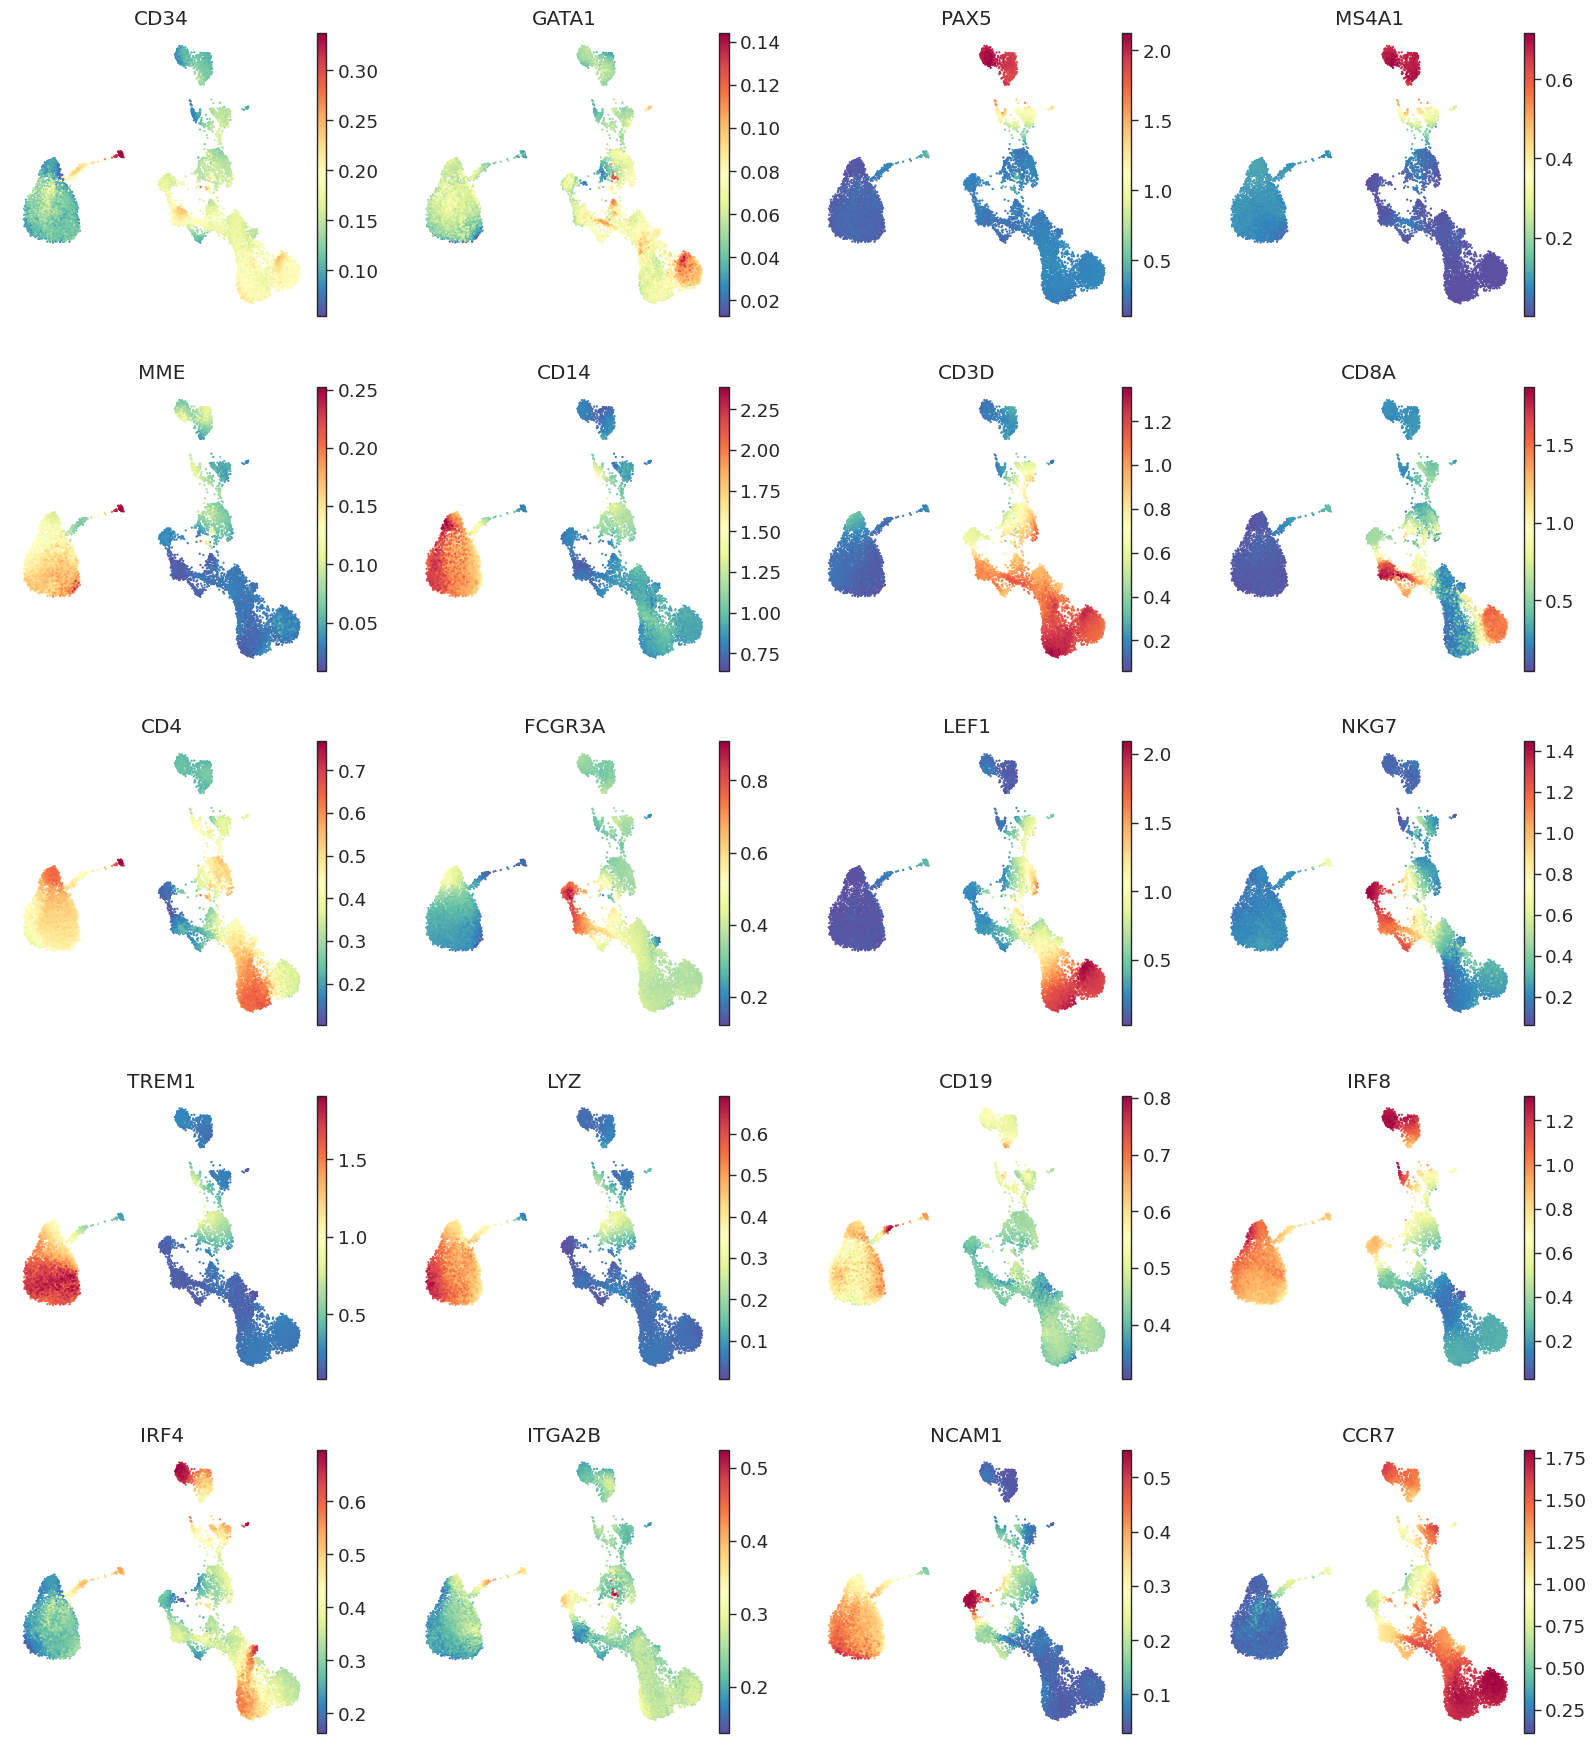

In [34]:
# Plot
temp = gs_ad[:, genes]
temp.layers['Imputed'] = imputed_data

sc.pl.embedding(temp, basis='umap', color=genes, layer='Imputed', frameon=False)

## ChromVAR

In [35]:
chromvar_ad = sc.AnnData(ad.obsm['chromVAR'])
chromvar_ad.obsm['X_umap'] = ad.obsm['X_umap_archr']

/loc/scratch/8137247/ipykernel_13047/3832574675.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  chromvar_ad = sc.AnnData(ad.obsm['chromVAR'])


In [36]:
# We will use all motifs since total < 1000
# Impute
data = pd.DataFrame(chromvar_ad.X, index=chromvar_ad.obs_names, columns=chromvar_ad.var_names)
chromvar_ad.layers['Imputed'] = impute_data_with_weights(ad, data)

In [37]:
chromvar_ad.var_names[chromvar_ad.var_names.str.contains('GATA|PAX')]

Index(['GATA1_383', 'GATA3_384', 'GATA5_385', 'GATA4_386', 'GATA6_387',
       'GATA2_388', 'PAX6_604', 'PAX7_605', 'PAX2_606', 'PAX4_607', 'PAX3_608',
       'PAX8_707', 'PAX1_708', 'PAX5_709', 'PAX9_710'],
      dtype='object')

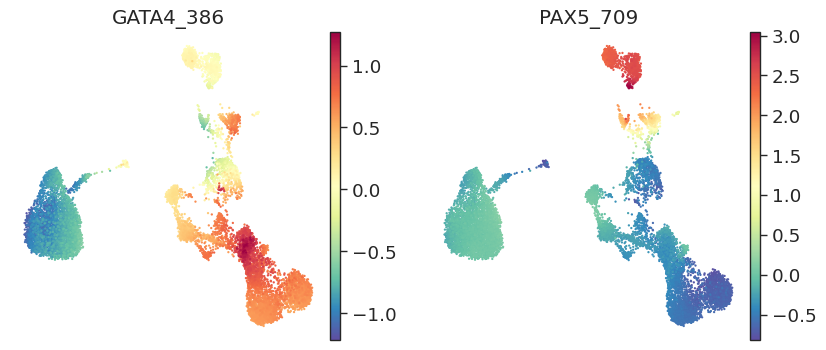

In [38]:
genes = ['GATA4_386', 'PAX5_709']
sc.pl.embedding(chromvar_ad, basis='umap', color=genes, layer='Imputed', frameon=False)

# Save

In [39]:
ad

AnnData object with n_obs × n_vars = 11049 × 150360
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColumns', 'features', 'DMEigenValues', 'Clusters_colors'
    obsm: 'X_svd', 'X_umap_archr', 'GeneScores', 'chromVAR', 'DM_EigenVectors'
    obsp: 'DM_Kernel', 'ImputeWeights'

In [41]:
ad.write('data/multiome/pbmc_multiome_atac.h5ad')